# Crew AI Flows

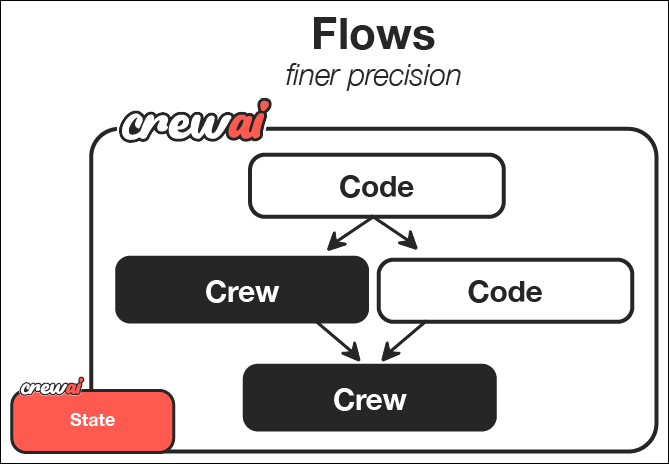

## Kenapa butuh Flow

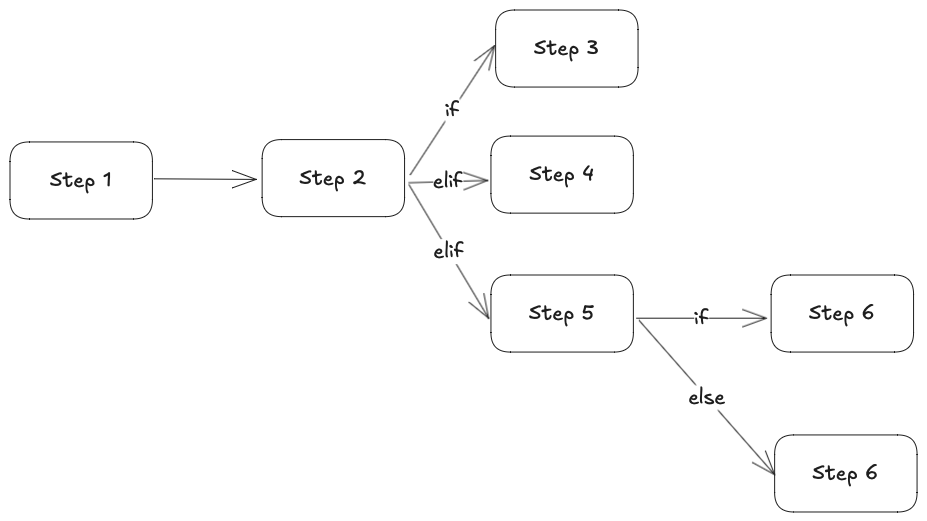

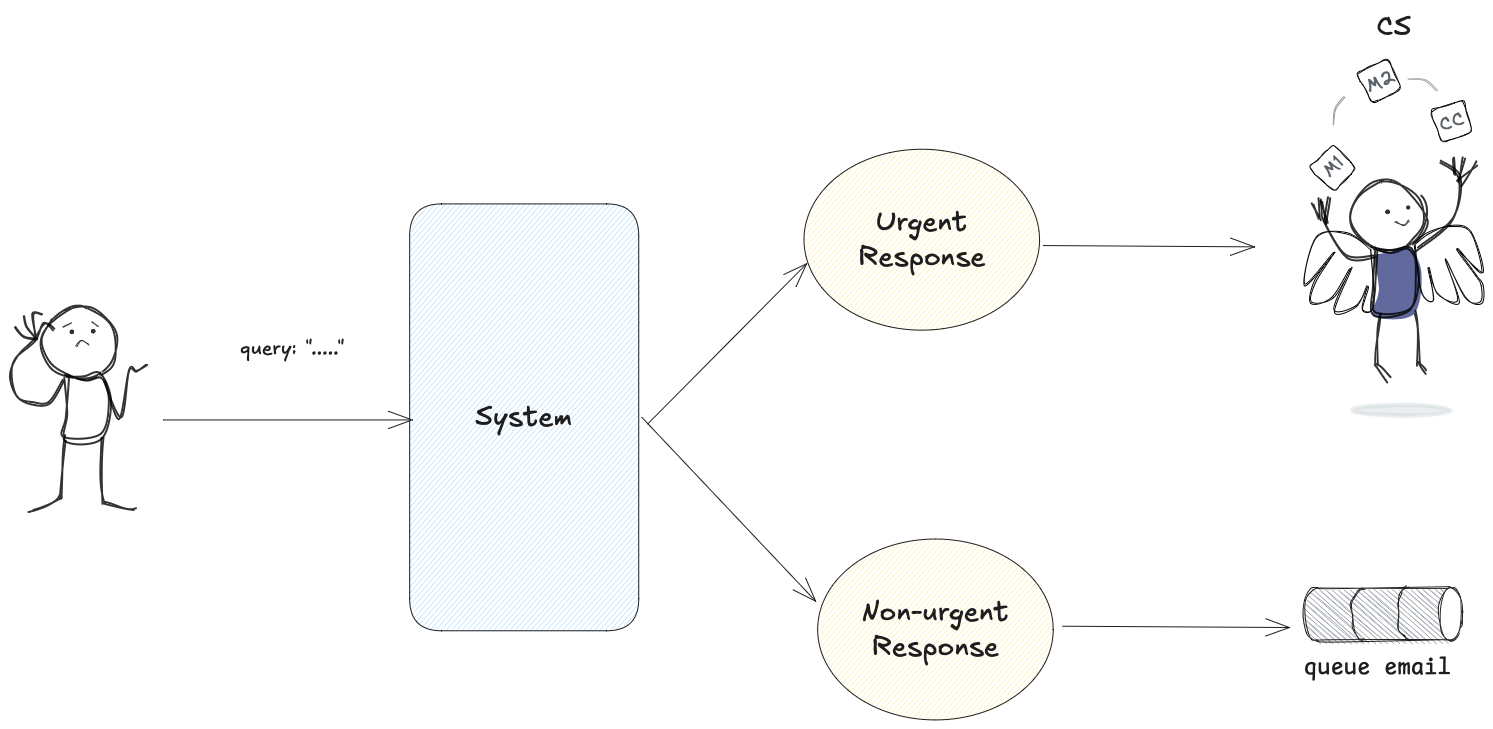

Tiga hal yang dibahas

1. Basic Flow

2. State

3. Conditional Flow

## Basic Flow

`@start` --> entry point dari flow

`@listen` --> ngebuat task nunggu sebuah task lain selesai dan langsung gunain outputnya

Jangan lupa buat .env dengan isi

`OPENAI_API_KEY=<>`

In [1]:
import os
import openai
from crewai.flow.flow import Flow, start, listen

openai_client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

class BookGenerationFlow(Flow):
    
    @start()
    def generate_title(self):
        response = openai_client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": "Buatkan saya sebuah judul menarik untuk buku dengan maksimal 9 kata yang dapat memikat pembaca.",
                },
            ],
        )

        random_title = response.choices[0].message.content.strip()

        return random_title

    @listen(generate_title)
    def generate_outline(self, random_title):
        response = openai_client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": f"""
                        Kami sedang menulis buku elektronik berjudul {random_title}.
                        Buatlah kerangka menyeluruh untuk buku ini yang akan memiliki 3 bab.
                        Setiap bab harus memiliki tepat 2 subbab. Format ouput untuk prompt: dictionary JSON dengan key: judul bab, value: sebuah list/array
                        yang berisi judul-judul subbab dalam bab tersebut. Judul bab harus diawali dengan nomor bab, seperti ini: 'Bab 5: [judul bab].'.
                        Judul subbab harus diawali dengan [nomor bab.nomor subbab], seperti ini: '5.4: [judul subbab]'
                    """,
                },
            ],
        )

        random_outline = response.choices[0].message.content.strip()

        return random_outline

In [2]:
flow = BookGenerationFlow()
final_result = await flow.kickoff_async()

print(f"\nBook Generation result: {final_result}")


Book Generation result: ```json
{
    "Bab 1: Awal Perjalanan Cinta": [
        "1.1: Mencari Jejak di Kota Pertama",
        "1.2: Ketersesatan yang Membawa Berkah"
    ],
    "Bab 2: Pertemuan Tak Terduga": [
        "2.1: Cinta di Tengah Keramaian",
        "2.2: Rahasia di Balik Senyuman"
    ],
    "Bab 3: Ujian dan Harapan": [
        "3.1: Menghadapi Rintangan Bersama",
        "3.2: Menemukan Kembali Jalan Cinta"
    ]
}
```


In [3]:
flow.state

{'id': '44975f94-247f-4260-a4d6-8794851fdde9'}

In [81]:
from IPython.display import Markdown

Markdown(final_result)

Berikut adalah kerangka menyeluruh untuk buku elektronik "Jejak Hati: Kisah Cinta yang Tak Terduga" dalam format JSON:

```json
{
    "Bab 1: Awal Mula Cerita": [
        "1.1: Pertemuan Tak Terduga",
        "1.2: Benih Cinta yang Tumbuh"
    ],
    "Bab 2: Ujian dan Rintangan": [
        "2.1: Tantangan dari Lingkungan",
        "2.2: Menghadapi Masa Sulit"
    ],
    "Bab 3: Cinta yang Bersemi": [
        "3.1: Momen-Momen Berharga",
        "3.2: Menjalin Komitmen"
    ]
}
``` 

Kerangka ini memberikan gambaran umum tentang struktur buku dan topik yang akan dibahas dalam setiap bab.

## Flow State

In [83]:
flow = BookGenerationFlow()
final_result = await flow.kickoff_async()

print(f"\nBook Generation result: {final_result}")


Book Generation result: ```json
{
    "Bab 1: Awal Mula Kisah Cinta": [
        "1.1: Pertemuan yang Tak Terduga",
        "1.2: Jalinan Perasaan dan Ketidakpastian"
    ],
    "Bab 2: Ujian dan Rintangan": [
        "2.1: Konsekuensi dari Pilihan",
        "2.2: Keberanian Menghadapi Tantangan"
    ],
    "Bab 3: Harapan dan Kebangkitan": [
        "3.1: Cinta yang Tak Pernah Padam",
        "3.2: Menemukan Kekuatan di Ujung Jalan"
    ]
}
```


Dua tipe state

1. Unstructured state --> lebih flexible dan dynamic

2. Structure state --> ada schema validation nya.

### Unstructured State

In [13]:
from crewai.flow.flow import Flow, listen, start
from pprint import pprint

class TaskManagementFlow(Flow):

    @start()
    def generate_task(self):
        print(f"Flow started. State ID: {self.state['id']}")
        
        self.state["task"] = "Benerin bug di payment system."
        self.state["status"] = "Pending"
        self.state["priority"] = "High"
        
        print(f"Task generated: {self.state['task']} (Status: {self.state['status']})")

    @listen(generate_task)
    def start_task(self):
        self.state["status"] = "In Progress"
        print(f"Task status updated: {self.state['status']}")

    @listen(start_task)
    def complete_task(self):
        self.state["status"] = "Completed"
        print(f"Task status updated: {self.state['status']}")
        print(f"Final Task State:")
        pprint(self.state)

In [14]:
flow = TaskManagementFlow()
final_result = await flow.kickoff_async()

Flow started. State ID: caf5ad11-7c9f-490f-b53f-0a5ade8a1fb4
Task generated: Benerin bug di payment system. (Status: Pending)
Task status updated: In Progress
Task status updated: Completed
Final Task State:
{'id': 'caf5ad11-7c9f-490f-b53f-0a5ade8a1fb4',
 'priority': 'High',
 'status': 'Completed',
 'task': 'Benerin bug di payment system.'}


### Structured State

In [6]:
from pydantic import BaseModel

class TaskState(BaseModel):
    task: str = "None"
    status: str = "None"

In [11]:
from crewai.flow.flow import Flow, listen, start
from pprint import pprint

class TaskManagementFlow(Flow[TaskState]):

    @start()
    def generate_task(self):
        print(f"Flow started. State ID: {self.state.id}")
        
        self.state.task = "Benerin bug di payment system."
        self.state.status = "Pending"
        self.state.priority = "High"
        print(f"Task generated: {self.state.task} (Status: {self.state.status})")

    @listen(generate_task)
    def start_task(self):
        self.state.status = "In Progress"
        print(f"Task status updated: {self.state.status}")

    @listen(start_task)
    def complete_task(self):
        self.state.status = "Completed"
        print(f"Task status updated: {self.state.status}")
        print(f"Final Task State:")
        pprint(self.state)

In [12]:
flow = TaskManagementFlow()
final_result = await flow.kickoff_async()

Flow started. State ID: 8188531b-65a6-4d24-bf35-911c48acc257


ValueError: "StateWithId" object has no field "priority"

## Flow Control

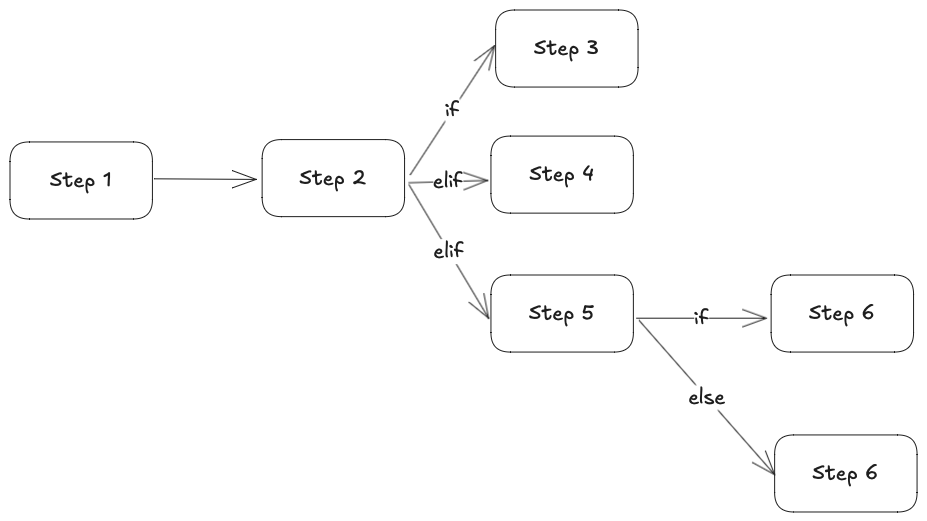

Tiga mekanisme flow control

`@or_`

`@and_`

`@router`

### Or Flow

In [17]:
from crewai.flow.flow import Flow, listen, or_, start

class CustomerSupportFlow(Flow):

    @start()
    def live_chat_request(self):
        return "Support request lewat live chat"

    @start()
    def email_ticket_request(self):
        return "Support request lewat email ticket"

    @listen(or_(live_chat_request, email_ticket_request))
    def log_request(self, request_source):
        print(f"Logging request: {request_source}")

In [18]:
flow = CustomerSupportFlow()
final_result = await flow.kickoff_async()

Logging request: Support request lewat live chat
Logging request: Support request lewat email ticket


### And Flow

In [19]:
from crewai.flow.flow import Flow, listen, and_, start

class AndFlow(Flow):

    @start()
    def step_one(self):
        print("Step 1: Collecting user input")
        return "User data"

    @start()
    def step_two(self):
        print("Step 2: Validating input")
        return "Validated data"

    @listen(and_(step_one, step_two))
    def final_step(self):
        print("All conditions met. Proceeding with final step.")

flow = AndFlow()
await flow.kickoff_async()

Step 1: Collecting user input
Step 2: Validating input
All conditions met. Proceeding with final step.


### Router Flow

In [21]:
from pydantic import BaseModel

class TicketState(BaseModel):
    priority: str = "low"

In [23]:
import random
from crewai.flow.flow import Flow, listen, router, start

class TicketManagementFlow(Flow[TicketState]):
    @start()
    def classify_ticket(self):
        self.state.priority = random.choice(["high", "low"])
        print(f"Ticket classified as: {self.state.priority}")

    @router(classify_ticket)
    def route_ticket(self):
        if self.state.priority == "high":
            return "direct_support"
        else:
            return "email_support"

    @listen("direct_support")
    def assign_to_cs(self):
        print("Urgent ticket assigned to a customer service!")

    @listen("email_support")
    def send_to_email_queue(self):
        print("Non-urgent ticket sent to email support queue.")

In [24]:
flow = TicketManagementFlow()
final_result = await flow.kickoff_async()

Ticket classified as: low
Non-urgent ticket sent to email support queue.
